In [4]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import util
import numpy as np
import heapq
from sklearn.decomposition import PCA

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')

df = pd.read_csv('data/test.csv', header = 0, sep = ",")
answers = df.iloc[:,1]
student_id = df.iloc[:,0]
sentences = []
for answer in answers:
    sentences.append(answer)
bert_embeddings = model.encode(answers)
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=2)
clustering_model.fit(bert_embeddings)
bert_label = clustering_model.labels_

df_clusters = pd.DataFrame({
    "id": student_id,
    "text": answers,
    "agg_bert_row": bert_label,
})


[[-0.22541061 -0.19388039]
 [ 0.54451871 -0.01331563]
 [ 0.00199625  0.10411049]
 [-0.40344722 -0.26686162]
 [ 0.05063044  0.04181397]
 [-0.04127735  0.14772102]
 [ 0.12269133  0.05520778]
 [-0.4693852  -0.25249487]
 [ 0.00786551  0.78520157]
 [-0.4693852  -0.25249487]
 [ 0.03157322  0.02006026]
 [ 0.00786551  0.78520157]
 [-0.07737083 -0.04968011]
 [-0.09201482 -0.08498987]
 [ 0.04074169 -0.1149681 ]
 [ 0.839315   -0.22592361]
 [-0.44571633 -0.25263452]
 [ 0.00351332 -0.18413335]
 [-0.13659416 -0.11519546]
 [ 0.26052043 -0.28692619]
 [ 0.07031962  0.21232555]
 [ 0.02695564  0.09783438]
 [ 0.09547349  0.21376393]
 [ 0.00786551  0.78520157]
 [-0.24803363 -0.04286796]
 [ 0.839315   -0.22592361]
 [-0.41329315 -0.23654337]
 [ 0.839315   -0.22592361]
 [ 0.12269133  0.05520778]
 [ 0.00786551  0.78520157]
 [-0.06911566 -0.04055042]
 [ 0.839315   -0.22592361]
 [-0.47427291 -0.17574887]
 [-0.14621416  0.03701778]
 [-0.21914512 -0.1533638 ]
 [ 0.839315   -0.22592361]
 [ 0.1010873   0.17673177]
 

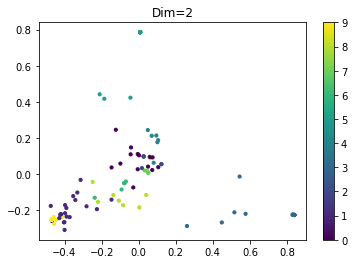

,id,text,agg_bert_row,x_position,y_position
0,1,Radical ideas,1,-0.225411,-0.193880
1,2,No judgement,3,0.544519,-0.013316
2,3,speed dating,0,0.001996,0.104110
3,4,Make multiple ideas,1,-0.403447,-0.266862
4,5,Yes and,0,0.050630,0.041814
...,...,...,...,...,...
105,106,Coming up with lots of ideas,1,-0.423064,-0.223820
106,107,Cluster and select,0,0.075199,0.092725
107,108,conversations take place on at a time,7,0.044080,0.019443
108,109,Be visual,5,0.007866,0.785202


In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 

# 初始化 PCA 降维模型
pca = PCA(n_components=2)
embedding_list = []
for i in bert_embeddings:
    embedding_list.append(i)
# 训练模型
compress_embedding = pca.fit_transform(embedding_list)
print(compress_embedding)
 
# 可视化
plt.scatter(compress_embedding[:, 0], compress_embedding[:, 1], s=10, c=bert_label)
plt.title("Dim=2")
plt.colorbar()
plt.show()

vector_2 = pd.DataFrame(compress_embedding)
df_clusters["x_position"] = vector_2.iloc[:,0]
df_clusters["y_position"] = vector_2.iloc[:,1]
df_clusters


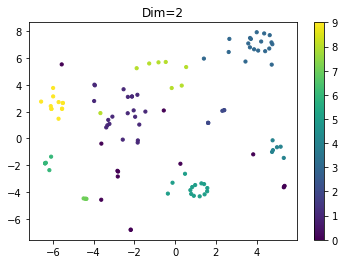

In [8]:
from sklearn.manifold import TSNE 

X_embedded = TSNE(n_components=2).fit_transform(embedding_list)
vector_2 = pd.DataFrame(compress_embedding)
df_clusters["x_position"] = vector_2.iloc[:,0]
df_clusters["y_position"] = vector_2.iloc[:,1]
df_clusters

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=10, c=bert_label)
plt.title("Dim=2")
plt.colorbar()
plt.show()

In [9]:
length = []
for i in range(0,len(student_id)):
    answer_length = len(answers[i])
    length.append(answer_length)
df_clusters["answer_length"] = length
    

计算每一类类中心的向量

In [10]:
clusters = {}
groups = {}
for i in range(0,len(student_id)):
    i_cluster = bert_label[i]
    if i_cluster not in clusters:
        groups[i_cluster] = 1
        clusters[i_cluster] = bert_embeddings[i]
    else:
        groups[i_cluster] +=1
        clusters[i_cluster] = clusters[i_cluster] + bert_embeddings[i]
# center of the cluster       
for key in clusters:
    clusters[key] = clusters[key]/groups[key]


找到每一个组的离群点（是否加入老师的input？）

In [26]:
distant_point = {}
distant_point_id = {}
for i in range(0, len(student_id)):
    i_cluster = bert_label[i]
    cos_sim = util.cos_sim(bert_embeddings[i], clusters[i_cluster])
    if i_cluster not in distant_point:
        distant_point[i_cluster] = cos_sim
        distant_point_id[i_cluster] = i
    else:
        if(cos_sim < distant_point[i_cluster]):
            distant_point[i_cluster] = cos_sim
            distant_point_id[i_cluster] = i

print(distant_point_id)

{1: 0, 3: 1, 0: 4, 2: 76, 9: 16, 5: 61, 7: 10, 6: 13, 8: 67, 4: 74}


老师可以在这里选择调整距离

In [56]:
influenced_points = {}
for key in distant_point_id:
    id = distant_point_id[key]
    if(distant_point[key]<0.8):
        key_vector = bert_embeddings[id]
        key_similarity_list = []
        for i in range(0,len(student_id)):
            cos_sim = util.cos_sim(bert_embeddings[id], bert_embeddings[i])
            key_similarity_list.append(cos_sim)
        influenced_points[key] = key_similarity_list

most_similar = {}
for key in influenced_points:
    max_index = []
    max_number = heapq.nlargest(6,influenced_points[key]) 
    for t in max_number:
        index = influenced_points[key].index(t)
        max_index.append(index)
        influenced_points[key][index] = 0
    most_similar[key] = max_index
dict = pd.DataFrame(pd.Series(most_similar))
dict = dict.reset_index().rename(columns={"index":"id"})
dict.columns=["id","most_similar_id"]
print(dict)
most_similar_answer = {}
distant_points = []
distant_point_answer = []
most_5_similar_id = [[]]
most_5_similar_text = []
for i in range(0, len(dict["id"])):
    most_distant_id = dict['most_similar_id'][i][0]
    most_distant_answer = df_clusters["text"][most_distant_id ]
    distant_points.append(most_distant_id)
    distant_point_answer.append(most_distant_answer)
    for j in range(0,5):
        next_distant_id = dict['most_similar_id'][i][j]
        print(i)
        print(j)
        print(dict['most_similar_id'][i][j])
        print(df_clusters["text"][next_distant_id])
        most_5_similar_id[i][j] = next_distant_id
dict["most_distant_id"] = distant_points
dict["most_distant_answer"] = distant_point_answer
dict

print(most_5_similar_id)
print(most_5_similar_text)



   id           most_similar_id
0   1  [0, 68, 95, 41, 104, 64]
1   3   [1, 15, 25, 27, 31, 35]
2   0   [4, 16, 21, 38, 98, 10]
3   5   [61, 48, 8, 11, 23, 29]
4   8   [67, 24, 1, 65, 14, 43]
5   4  [74, 36, 20, 22, 99, 80]
0
0
Radical ideas 


IndexError: list assignment index out of range